<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher/blob/main/WholeRightHand_Vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install vit_pytorch timm
#timmとは、Ross Wightman によって作成された深層学習ライブラリ。

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.6/93.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.2 MB/s eta 0:00:00


# ライブラリのインストール

In [3]:
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint

In [8]:
from PIL import Image
import os
!pip install pyheif

# 変換する画像が含まれるディレクトリのパス
input_dir = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/nonRA/nonRA_Right_Hand'
output_dir = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/nonRA/nonRA_Right_Hand'


def heic_convert_to(heic_filename, output_filename, q=90):
    import pyheif
    from PIL import Image

    heif = pyheif.read(heic_filename)

    image = Image.frombytes(
        heif.mode,
        heif.size,
        heif.data,
        "raw",
        heif.mode,
        heif.stride,
    )

    image.save(output_filename, quality=q)

for filename in os.listdir(input_dir):
    if filename.lower().endswith('.heic'):
        input_filepath = os.path.join(input_dir, filename)
        output_filepath = os.path.join(output_dir, os.path.splitext(filename)[0] + '.jpeg')

        try:
            heic_convert_to(input_filepath, output_filepath)
            print(f"Converted {filename} to JPEG")
        except Exception as e:
            print(f"Couldn't convert {filename}: {e}")

Converted IMG_1797 - Ho2O hO2O.HEIC to JPEG
Converted IMG_2324 - Yuuki Uchida.HEIC to JPEG
Couldn't convert IMG_6586 - あこすあこす.HEIC: Input is not a HEIF/AVIF file
Converted IMG_1907 - Manami Okamura.HEIC to JPEG
Converted IMG_9517 - kujilife.HEIC to JPEG
Converted IMG_7199 (2) - Akira Ishida.HEIC to JPEG
Converted IMG_9772 - 虎金六知ひーやん.HEIC to JPEG
Converted 85597DAA-3D79-48F4-9D3A-B2D814E104C2_1_201_a - u akitakeru.heic to JPEG
Converted IMG_3830 - TA KE.HEIC to JPEG
Converted CFB65066-75A1-41BA-8A5F-647920ED0899 - T T (瀧).heic to JPEG
Converted IMG_8542 - 長尾早希.HEIC to JPEG
Converted IMG_5739 - 黒川京子.HEIC to JPEG
Converted IMG_1981 - Ayaka Saito.HEIC to JPEG
Converted IMG_3200 - 星空.HEIC to JPEG
Converted 4F665B36-1D03-40F8-BCD6-6FE616E12B22 - 茅原陽子.heic to JPEG
Converted IMG_7850 - 稲美.HEIC to JPEG
Converted IMG_7729 - mayu.HEIC to JPEG
Converted IMG_3821 - KT_DB.HEIC to JPEG
Converted IMG_0350 - Yuki Nakazawa.HEIC to JPEG
Converted 9ACDA11C-8900-4391-B5CA-CB03144BE301 - 桃式会社Liam.heic to JP

In [9]:
def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.7, 0.2, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))
# データのバックアップ
#shutil.copytree('/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/RA/RA_Right_Hand/',
                #'/content/drive/MyDrive/OptPhotoFiles/backup/optPhotoFiles/RA_Right_Hand/')
#shutil.copytree('/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/nonRA/nonRA_Right_Hand/',
                #'/content/drive/MyDrive/OptPhotoFiles/backup/optPhotoFiles/nonRA_Right_Hand/')

def rename_files(directory, prefix, start_number=1):
    counter = start_number
    for foldername, subfolders, filenames in os.walk(directory):
        for filename in filenames:
            # ファイルの絶対パスを取得
            filepath = os.path.join(foldername, filename)

            # 新しいファイル名を作成
            new_filename = f"{prefix}_{str(counter).zfill(6)}{os.path.splitext(filename)[1]}"
            new_filepath = os.path.join(foldername, new_filename)

            # ファイル名を変更
            os.rename(filepath, new_filepath)

            counter += 1

rename_files('/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/RA/RA_Right_Hand/', 'patients')
rename_files('/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/nonRA/nonRA_Right_Hand/', 'healthy_control')

src_dir_RA = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/RA/RA_Right_Hand/'
train_dest_RA = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/Right_Hand/train/RA_Right_Hand'
val_dest_RA = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/Right_Hand/val/RA_Right_Hand'
test_dest_RA = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/Right_Hand/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/nonRA/nonRA_Right_Hand/'
train_dest_nonRA = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/Right_Hand/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/Right_Hand/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/Right_Hand/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)

# 学習条件、ランダムシードの設定

In [20]:
# Training settings
epochs = 30
# lr = 0.01
lr = 1e-3#学習率(learning rate: lr)
gamma = 0.7#更新率。デフォルトは0.1。この場合、更新タイミングで学習率が1/10になる
seed = 42#乱数のシード。慣用的に42が使用されることが多い。
#「銀河ヒッチハイク・ガイド」という書籍の中で登場するスーパーコンピューターのディープ・ソートが「生命、宇宙、そして万物についての究極の疑問の答え」として計算した数字

In [11]:
def seed_everything(seed):#使用するモジュールにおける乱数のシードを統一し、再現性を確保している。
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)#その他さまざまなtorchに含まれる非決定的な計算過程を決定的なものにして再現性を確保している

In [12]:
# GPUの設定
device = 'cuda'

# データセットの前処理

In [13]:
from torchvision import transforms

# 前処理の定義
train_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    #transforms.Grayscale(num_output_channels=3), # グレースケール画像を3チャンネルに変換
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# データセットのロード

In [14]:
from torchvision.datasets import ImageFolder
# 画像のパス
train_dir = "/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/Right_Hand/train"
val_dir = "/content/drive/MyDrive/OptPhotoFiles/optPhotoFiles/Right_Hand/val"

from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            # 代わりの画像を返す
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0  # または適切なクラスのインデックス
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)

# データローダの定義
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=16, shuffle=False)  # 検証中はシャッフル不要

In [11]:
for i, (images, labels) in enumerate(train_loader):
    if i > 5:  # 最初の5バッチだけを表示
        break
    print(labels)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])
tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])


データをバッチに分ける。

今回バッチサイズは16にするが、メモリが足らない場合は数字をあげる。

# Vitモデルのロード


In [15]:
model_names = timm.list_models(pretrained=True)
# ファインチューニングしたい場合はpretrained=True
# model_names = timm.list_models(pretrained=True)
#pprint(model_names)

今回は'vit_base_patch16_224_in21k'を選んでみる

In [16]:
model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)
# 訓練済みデータを使用しない場合はpretrained=Falseとする。訓練済みデータを使用し、ファインチューニングしたい場合はpretrained=True
# model = timm.create_model('vit_base_patch16_224_in21k', pretrained=True, num_classes=2)

# modelをGPUで動作させる
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

# Vit学習

損失関数、活性化関数の設定をする。

今回はクロスエントロピーロス、アダムを使う。

In [17]:
# loss function
criterion = nn.CrossEntropyLoss()#正常と異常の２値分類であるためクロスエントロピー法を用いる。
# criterion = nn.HuberLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)#パラメーターはデフォルト値を使用する。学習率は上記に定めたものを使用
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

学習ループを設定し、実行していく

In [21]:
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
    #ここからが訓練用データの解析
for epoch in range(epochs):#訓練するエポックの数だけループを行う。エポック数は全データセットを何回学習に通すかを示す。
    epoch_loss = 0#各エポックの初めで、エポックのlossをゼロに初期化する。
    epoch_accuracy = 0#各エポックの初めで、エポックのaccuracyをゼロに初期化する。

    for data, label in tqdm(train_loader):#訓練データローダーからバッチを取得する。tqdmはプログレスバーを表示するためのライブラリ。
        data = data.to(device)#取得した画像をGPUに移す（もしCUDAが利用可能なら）。deviceは通常、'cuda'または'cpu'となる。
        label = label.to(device)#取得したラベルをGPUに移す。

        output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
        loss = criterion(output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

        optimizer.zero_grad()#勾配をゼロに初期化する。PyTorchでは勾配が累積されるため、各バッチでゼロにリセットする必要がある。
        loss.backward()#損失関数を用いて求めた損失から、誤差逆伝播法を使用して勾配を計算する。
        optimizer.step()#計算された勾配を用いて、最適化アルゴリズム（ここではAdam）によりモデルのパラメータ（係数と切片）を更新する。

        acc = (output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。argmax関数で、出力から最も確率が高いクラスを選ぶ。それがラベルと一致しているか確認し、平均値を取る。
        epoch_accuracy += acc / len(train_loader)#バッチごとの正確さを加算する。全バッチを通した後、これらの値はエポック全体の平均した正確さになる。
        epoch_loss += loss / len(train_loader)#バッチごとの損失を加算する。全バッチを通した後、これらの値はエポック全体の平均した損失になる。

    #ここからが検証用データの解析
    with torch.no_grad():#勾配の計算を無効にするコンテキストマネージャ。モデルを評価する際には、勾配の計算は不要であり、計算量を削減することができる。
        epoch_val_accuracy = 0#各エポックの初めで、検証したエポックの正確さをゼロに初期化する。
        epoch_val_loss = 0#各エポックの初めで、検証したエポックの損失をゼロに初期化する。
        for data, label in valid_loader:#検証データローダーからバッチを取得する。
            data = data.to(device)#取得した画像をGPUに移す
            label = label.to(device)#取得したラベルをGPUに移す
        #以降の部分は基本的に訓練ループと同じ。
        #ただし、検証過程ではモデルのパラメータを更新する必要がないため、optimizer.zero_grad(), loss.backward(), optimizer.step()の部分は含まれていない。
            val_output = model(data)#モデルに入力データを通すことで、出力（推定値）を求める。
            val_loss = criterion(val_output, label)#出力（推定値）とラベル（実測値）を用いて、損失関数（ここではCross Entropy Loss）を使用して損失を計算する。

            acc = (val_output.argmax(dim=1) == label).float().mean()#予測モデルの正確さを計算する。
            epoch_val_accuracy += acc / len(valid_loader)#バッチごとの正確さを加算する。
            epoch_val_loss += val_loss / len(valid_loader)#バッチごとの損失を加算する。

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1488 - acc: 0.9512 - val_loss : 0.1944 - val_acc: 0.9269



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.1494 - acc: 0.9474 - val_loss : 0.1907 - val_acc: 0.9234



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.1397 - acc: 0.9492 - val_loss : 0.1568 - val_acc: 0.9477



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.1026 - acc: 0.9653 - val_loss : 0.1337 - val_acc: 0.9477



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.1273 - acc: 0.9621 - val_loss : 0.1465 - val_acc: 0.9475



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.1127 - acc: 0.9593 - val_loss : 0.1777 - val_acc: 0.9477



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.1406 - acc: 0.9522 - val_loss : 0.2095 - val_acc: 0.9234



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0978 - acc: 0.9660 - val_loss : 0.1748 - val_acc: 0.9410



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.1368 - acc: 0.9554 - val_loss : 0.2109 - val_acc: 0.9303



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0893 - acc: 0.9722 - val_loss : 0.1672 - val_acc: 0.9512



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.1151 - acc: 0.9569 - val_loss : 0.1340 - val_acc: 0.9512



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.1175 - acc: 0.9571 - val_loss : 0.2084 - val_acc: 0.9373



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.1203 - acc: 0.9554 - val_loss : 0.1385 - val_acc: 0.9581



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.1052 - acc: 0.9621 - val_loss : 0.1625 - val_acc: 0.9581



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.1102 - acc: 0.9623 - val_loss : 0.1776 - val_acc: 0.9373



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.1736 - acc: 0.9393 - val_loss : 0.2151 - val_acc: 0.9368



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.1118 - acc: 0.9554 - val_loss : 0.1336 - val_acc: 0.9581



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.1069 - acc: 0.9633 - val_loss : 0.1113 - val_acc: 0.9685



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0978 - acc: 0.9683 - val_loss : 0.1057 - val_acc: 0.9688



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.1287 - acc: 0.9554 - val_loss : 0.2244 - val_acc: 0.9269



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.1273 - acc: 0.9534 - val_loss : 0.1251 - val_acc: 0.9618



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.0793 - acc: 0.9702 - val_loss : 0.1472 - val_acc: 0.9650



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.0860 - acc: 0.9692 - val_loss : 0.1252 - val_acc: 0.9650



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.0878 - acc: 0.9702 - val_loss : 0.1325 - val_acc: 0.9618



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.0908 - acc: 0.9722 - val_loss : 0.1408 - val_acc: 0.9512



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.0701 - acc: 0.9772 - val_loss : 0.1512 - val_acc: 0.9514



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.1036 - acc: 0.9583 - val_loss : 0.1903 - val_acc: 0.9405



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.1025 - acc: 0.9603 - val_loss : 0.2024 - val_acc: 0.9303



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.1017 - acc: 0.9623 - val_loss : 0.1590 - val_acc: 0.9479



  0%|          | 0/63 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.1156 - acc: 0.9583 - val_loss : 0.1503 - val_acc: 0.9581



# 学習結果の可視化

<ipython-input-22-a14de596ddeb>:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1,2,1)


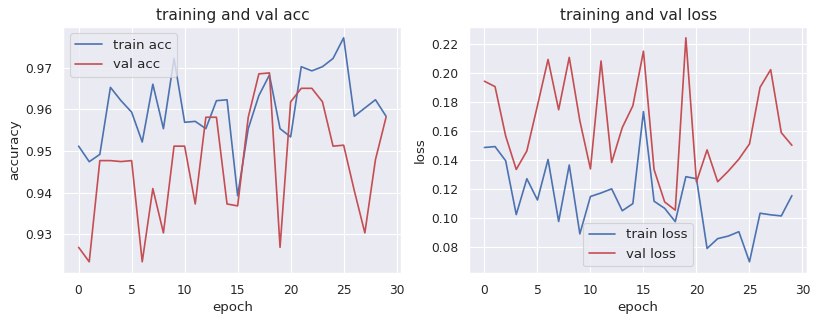

In [22]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)

    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)

    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)

    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()